In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import tensorflow as tf

import random

import cv2

2025-12-17 09:01:29.499198: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-17 09:01:29.520751: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-17 09:01:29.520775: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-17 09:01:29.521414: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-17 09:01:29.525330: I tensorflow/core/platform/cpu_feature_guar

# N-Way, K-Shot

In Supervised Learning, the dataset is split into training, validation, and test sets. In FSL the dataset is split into training sets and test sets, whereas the  sets consist of a so-called **support set** and a **query set**.

The support set contains
* N classes (`NUM_CLASSES`)
* K samples per class (`NUM_SAMPLES_PER_CLASS`)

For example, in the **common 5-way, 1-shot** image classification scenario, one support set contains 1 example for each of the 5 classes.

In the following notebook, we will sample batches for training a Few-Shot Classification model by creating a `DataLoader` with the aid of the Omniglot dataset.

In [2]:
NUM_CLASSES = 5
NUM_SAMPLES_PER_CLASS = 1

# Omniglot Dataset

The Omniglot data set was proposed by Lake et al. and consists of:
* 1623 characters 
* from 50 different alphabets
* each character has 20 instances
* each image is a grayscale image
* each image is 105 x 105 pixels

**Note:** Recent advances in FSL have achieved high accuracies for the Omniglot dataset (e.g. MAML XX %). Therefore, new datasets, such as the meta-dataset have been introduced. However, the Omniglot dataset is sufficient for the purpose of this script.

**In contrast to the MNIST dataset**, which is commonly used for image classification in the traditional Supervised Learning setting, the Omniglot dataset has many different classes (MNIST only has 10 classes) but only 20 instances of each character (MNIST contains many instances for each character).

In [3]:
PATH = "../../../omniglot"

# Get all alphabet folders
alphabet_folders = [os.path.join(os.path.join(PATH, folder, alphabet))
                    for folder in os.listdir(PATH)
                        if os.path.isdir(os.path.join(PATH, folder))
                            for alphabet in os.listdir(os.path.join(PATH, folder))
                                if os.path.isdir(os.path.join(PATH, folder, alphabet))]

print(f"The dataset contains {len(alphabet_folders)} alphabets.")

# Get all character folders
character_folders = [os.path.join(os.path.join(alphabet_path, character))
                     for alphabet_path in alphabet_folders
                         for character in os.listdir(alphabet_path)
                             if os.path.isdir(os.path.join(alphabet_path, character))]

# Sort alphabetically 
character_folders = sorted(character_folders)

print(f"The dataset contains {len(character_folders)} characters.")

# Get all images
all_files = list()
for (dirpath, dirnames, filenames) in os.walk(PATH):
    all_files += [os.path.join(dirpath, file) for file in filenames]
print(f"The dataset contains {len(all_files)} images.")

The dataset contains 53 alphabets.
The dataset contains 1631 characters.
The dataset contains 70782 images.


In [4]:
def read_and_preprocess_image(img_path, image_dim=None):
    """
    Takes an image path and returns a grayscale, resized, and flattened image as array
    
    Args:
    * img_path: Full path to file
    * image_dim: Resized image shape (width, height)
    
    Returns:
    a grayscale, resized, and flattened image
    """
    # Read image as grayscale
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    # Resize image
    if image_dim is not None:
        img = cv2.resize(img, image_dim, interpolation = cv2.INTER_AREA) 
    
    img = img.astype(np.float32) / 255.0
    img = 1.0 - img
    img = img.reshape(-1)
    return img

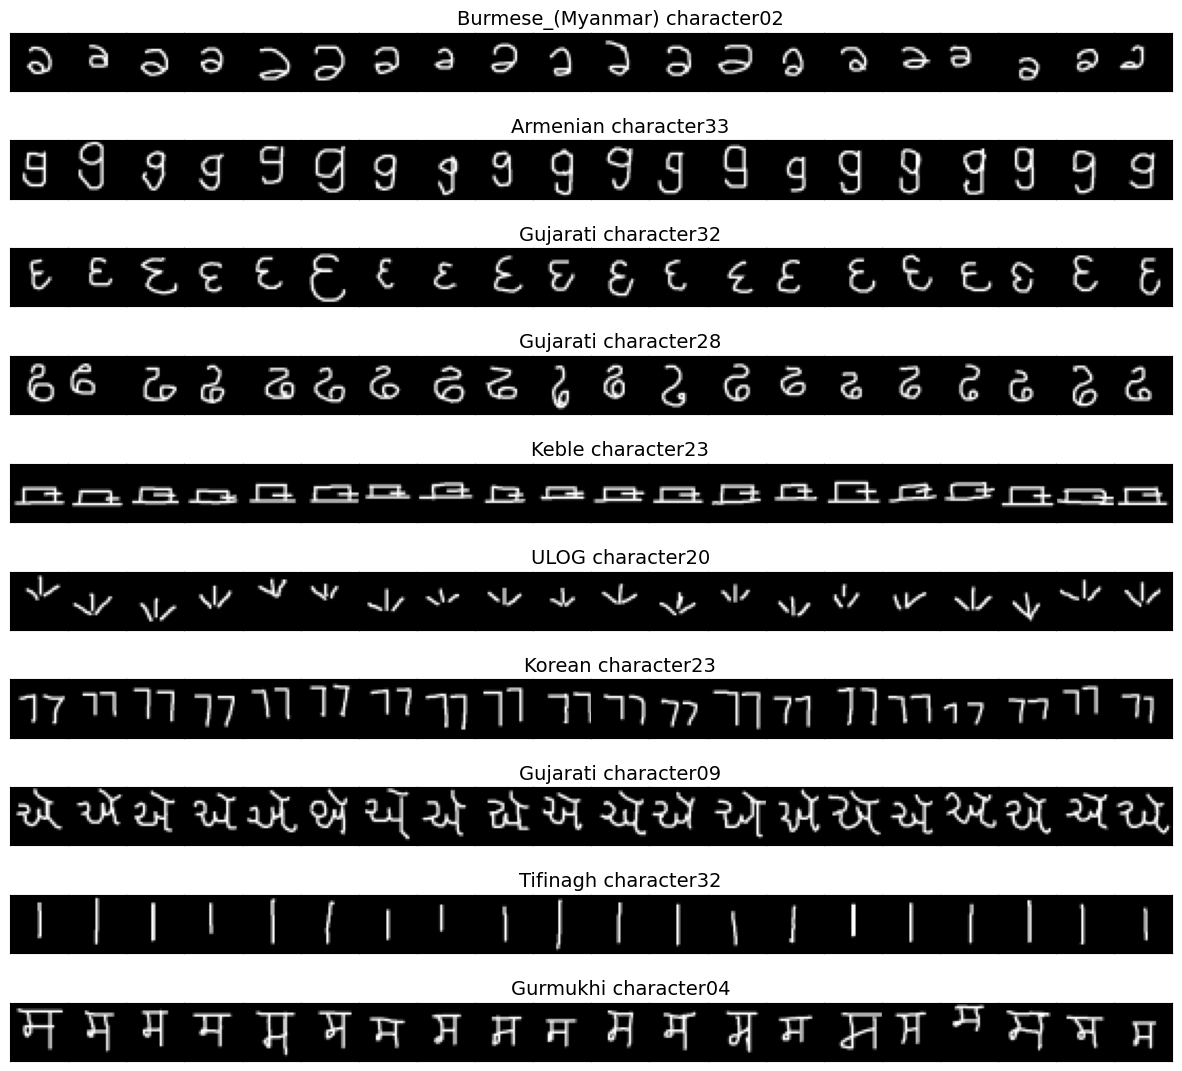

In [5]:
fig, axes = plt.subplots(nrows=10, ncols=20, figsize=(15, 14), gridspec_kw = {'wspace':0, 'hspace':0})

for i, row in enumerate(axes):
    # Get random character
    random.seed(i+1)
    character_index = random.randint(0,len(character_folders))
    
    # Get alphabet name, character number, and images
    alphabet_name = character_folders[character_index].split('/')[-2]
    character_number = character_folders[character_index].split('/')[-1]
    files = os.listdir(character_folders[character_index])
    
    # Plot all image instances
    for j, col in enumerate(row):
        img_path = os.path.join(character_folders[character_index], files[j])
        img = read_and_preprocess_image(img_path, (28, 28))
        col.imshow(img.reshape([28, 28]), cmap='gray')
        col.set_xticks([])
        col.set_yticks([])
        col.set_xticklabels([])
        col.set_yticklabels([])
        # Set title in the middle
        if j == 10:
            col.set_title(f"{alphabet_name} {character_number}", fontsize=14)

# Data Loader
Now, we will create a `DataLoader` that samples batches of size `BATCH_SIZE`.

In [ ]:
BATCH_SIZE = 16

class DataLoader():
    """
    Data Loader Few-Shot Learning 
    Forked from https://github.com/cbfinn/maml
    """

    def __init__(self, num_classes, num_samples_per_class):
        """
        args:
        * num_classes: N classes in support set 
        * num_samples_per_class: K samples per class in support set
        """
        self.num_classes = num_classes
        self.num_samples_per_class = num_samples_per_class
        print(f"Data Loader for {num_classes}-way, {num_samples_per_class}-shot Few-Shot Learning.")
        
        # Dataset specific
        self.meta_train_folders = "../../../omniglot/images_background"
        self.meta_val_folders = "../../../omniglot/images_evaluation"
        self.meta_test_folders = "../../../omniglot/images_evaluation"

    def sample_batch(self, batch_type, batch_size):
        """
        returns:
        * image_batch with shape [batch_size, num_classes, num_samples_per_class, (im_size * im_size)]
        * label_batch with shape [batch_size, num_classes, num_samples_per_class, num_classes]
        """
        all_image_batches, all_label_batches = [], []

        # Set the folder according to purpose
        base_path = None
        if batch_type == 'train':
            base_path = self.meta_train_folders
        elif batch_type == 'val':
            base_path = self.meta_val_folders
        elif batch_type == 'test':
            base_path = self.meta_test_folders
        else: 
            print(f"Error: '{batch_type}' is not a valid value for batch_type. batch_type must be either one of 'train', 'val', 'test'.")

        assert base_path != None
        folders = [os.path.join(base_path, folder, character)
                      for folder in os.listdir(base_path)
                      for character in os.listdir(os.path.join(base_path, folder))]

        for _ in range(batch_size):
            # Sample N different classes from the folders
            sampled_character_folders = random.sample(folders, self.num_classes)

            # Sample K images per class and associate labels
            sampler = lambda x: random.sample(x, self.num_samples_per_class)
            labels_and_images = [(i, os.path.join(path, image)) \
                for i, path in zip(range(self.num_classes), sampled_character_folders) \
                for image in sampler(os.listdir(path))]

            labels = [li[0] for li in labels_and_images]
            images = [read_and_preprocess_image(li[1], (28, 28)) for li in labels_and_images]

            # Format images to fit [num_classes, num_samples_per_class, (im_size * im_size)]
            images = np.stack(images)
            images = np.reshape(images, (self.num_classes, self.num_samples_per_class, -1))

            # Format labels one-hot encoded to fit [ num_classes, num_samples_per_class, num_classes]
            labels = np.array(labels)
            labels = np.reshape(labels, (self.num_classes, self.num_samples_per_class))
            labels = np.eye(self.num_classes)[labels]

            batch = np.concatenate([labels, images], 2)

            # Shuffle classes such that classes are not associated with the order
            for p in range(self.num_samples_per_class):
                np.random.shuffle(batch[:, p])
                
            labels = batch[:, :, :self.num_classes]
            images = batch[:, :, self.num_classes:]

            all_image_batches.append(images)
            all_label_batches.append(labels)
            
        all_image_batches = np.stack(all_image_batches)
        all_label_batches = np.stack(all_label_batches)

        return all_image_batches, all_label_batches

Let's have a look at what a **5-way, 5-shot support set** looks like

Data Loader for 5-way, 2-shot Few-Shot Learning.
Image batch shape: (16, 5, 2, 784)
Label batch shape: (16, 5, 2, 5)


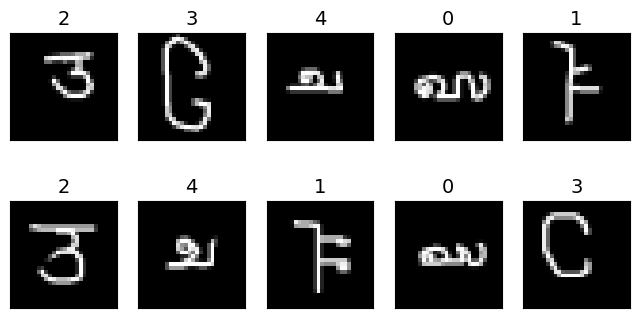

In [ ]:
data_loader = DataLoader(NUM_CLASSES, 5)   

im_batch, l_batch = data_loader.sample_batch("train", BATCH_SIZE)

print(f"Image batch shape: {im_batch.shape}")
print(f"Label batch shape: {l_batch.shape}")

fig, axes = plt.subplots(nrows=2, ncols=NUM_CLASSES, figsize=(8, 4))
batch_idx = 0

for i, row in enumerate(axes): # NUM_SAMPLES_PER_CLASS
    for j, col in enumerate(row): # NUM_CLASSES
        col.imshow(im_batch[batch_idx, j, i].reshape([28, 28]), cmap='gray')
        col.set_title(f"{np.argmax(l_batch[batch_idx, j, i])}", fontsize=14)
        col.set_xticks([])
        col.set_yticks([])
        col.set_xticklabels([])
        col.set_yticklabels([])

And finally, let's have a look at what a **5-way, 1-shot batch** looks like

Data Loader for 5-way, 1-shot Few-Shot Learning.
Image batch shape: (16, 5, 1, 784)
Label batch shape: (16, 5, 1, 5)


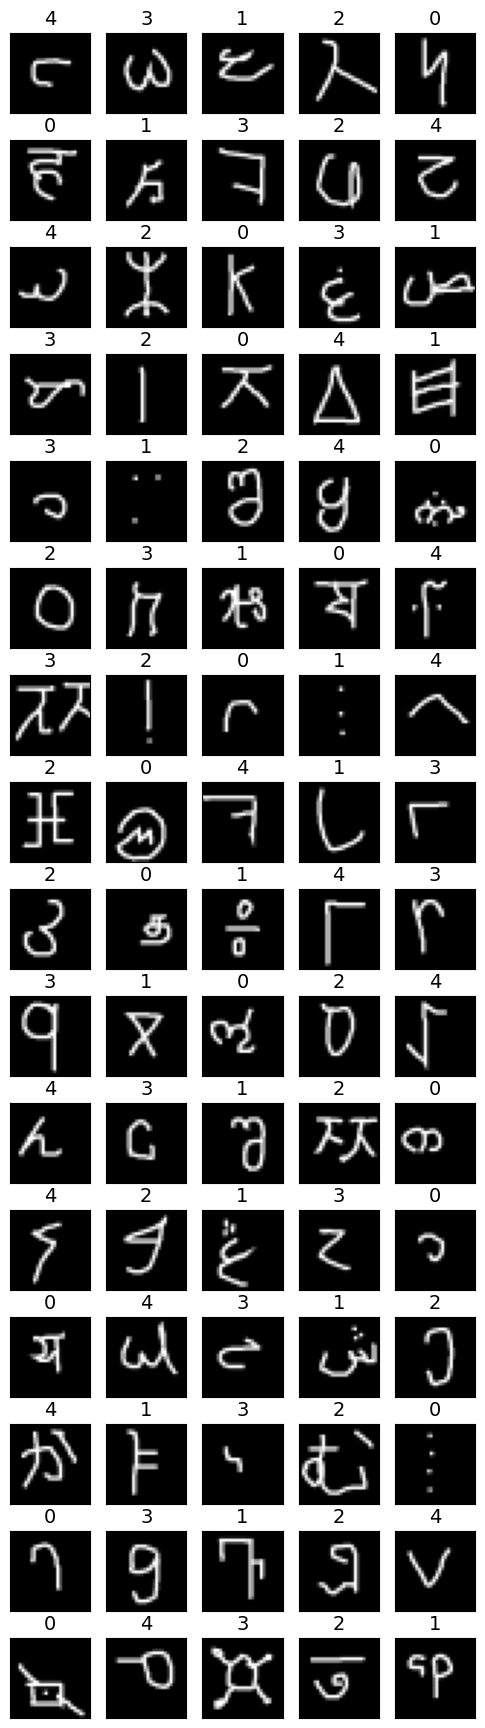

In [10]:
data_loader = DataLoader(NUM_CLASSES, NUM_SAMPLES_PER_CLASS)   

im_batch, l_batch = data_loader.sample_batch("train", BATCH_SIZE)

print(f"Image batch shape: {im_batch.shape}")
print(f"Label batch shape: {l_batch.shape}")

fig, axes = plt.subplots(nrows=BATCH_SIZE, ncols=NUM_CLASSES, figsize=(6, 22))

for i, row in enumerate(axes): # BATCH_SIZE
    for j, col in enumerate(row): # NUM_CLASSES
        col.imshow(im_batch[i, j, 0].reshape([28, 28]), cmap='gray')
        col.set_title(f"{np.argmax(l_batch[i, j, 0])}", fontsize=14)
        col.set_xticks([])
        col.set_yticks([])
        col.set_xticklabels([])
        col.set_yticklabels([])